In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Represent state as both a number and state data
Transformation matrix requires that state has to be turned into a number, for readability the class allows both.
How to map game state (inning, half, outs, bases, home score, away score) is somewhat arbitrary, and choices are mostly done for simplicity's sake.

A state is represented as an inning (which includes the half), the bases (represented by one number from converting the 3 digit binary base states), outs, and the score (home team - away team).

    inning = [0,17]
    outs = [0,2]
    bases = [0,8]
    score = [-15,15]

Matrix is finite, so data that has extra innings or a score difference greater than 15 (negative or positive) are thrown out.

Converting from state to number:

    Every unique state maps to a unique number: [0, # of possible states - 1]
    Simple conversion: (score + 15)*18*8*3 + (inning)*8*3 + (bases)*3 + (outs)
    Adding 15 to score is to change the range of score from [-15, 15] to [0, 30]

Lastly to determine when a game has ended a couple flags are used by reserving 3 states (home win, home loss, draw) which normally could never occur:
    
    (Since the away team bats first, score can't be positive in the first inning)
    Home win flag: inning = 0, outs = 0, bases = 0, score = 1
    Away win flag: inning = 0, outs = 0, bases = 0, score = 2
    Draw flag:     inning = 0, outs = 0, bases = 0, score = 3
    
    Note that while the draw flag is still available to use, it shouldn't ever be utilized.

In [2]:
#gameState represents any state in a baseball game, each state can be represented by either members or as one number
#note: end flags, they are inning = 0, outs = 0, bases = 0, score = 1,2,3 (since these states are impossible in normal play)
#if flag score is 1 (home win), 2 (away win), 3 (draw state at end of 17th (9th) inning)
class gameState:
    inning = 0 #[0,17] since each of the 9 innings are either in the top or the bottom
    outs = 0 #[0, 2] number of outs
    bases = 0 #[0,7] binary representation, i.e. 6 (110) has runners on 2nd and 3rd
    score = 0 #score = homeTeamScore - awayTeamScore, for simplicity score = [-15, 15]

    def setFromInfo(self, inn, out, bas, scor): #construct from data, note: base should be a 3 element list like [0,1,1]
        if(inn > 17):
            inn = 16 + int(inn % 2 == 0)
        self.inning = inn
        self.outs = out
        self.bases = 4*bas[2] + 2*bas[1] + bas[0] #conversion from list format to single number
        
        self.score = max(-15, min(15, scor)) #score between -15 and 15
        
    def setFromData(self, inn, out, bas, scor): #construct from data, note: base should be [0,7]
        if(inn > 17):
            inn = 16 + int(inn % 2 == 0)
        self.inning = inn
        self.outs = out
        self.bases = bas
        
        self.score = max(-15, min(15, scor)) #score between -15 and 15

    def setFromNum(self, numEquiv): #construct from number, map number to gameState
        self.outs = numEquiv % 3
        numEquiv = numEquiv // 3
        
        self.bases = numEquiv % 8
        numEquiv = numEquiv // 8
        
        self.inning = (numEquiv % 18)
        numEquiv = numEquiv // 18
        
        self.score = (numEquiv % 31) - 15
        
    def __str__(self): #for convient printing, note bases are printed as 1,2,3 not 3,2,1
        return ("{'Inning': " + str(self.inning) + ", " 
            + "'Outs': " + str(self.outs) + ", "
            + "'Bases': " + str(self.bases % 2) + str((self.bases >> 1) % 2) + str(self.bases >> 2) + ", "
            + "'Score': " + str(self.score) + "}")
    
    def toNum(self): #map gameState to number
            return (self.score + 15)*18*8*3 + (self.inning)*8*3 + (self.bases)*3 + (self.outs)
    
    def setEndFlagState(self, lastState): #set the end flag state from the last state of the game, asssume lastState is an end
        self.inning = 0
        self.outs = 0
        self.bases = 0
        self.score = 3 #draw
        if(lastState.score < 0): #away win
            self.score = 2
        elif(lastState.score > 0): #home win
            self.score = 1
        else: #game ended in overtime or last inning
            if(lastState.inning % 2 == 0): #away team batted last
                self.score = 2 #away team won
            else: #home team batted last
                self.score = 1 #home team won
                     
    def isEndState(self): #check if the state is an end state
        if(self.inning != 0 or self.outs != 0 or self.bases != 0): #not an end state if any of these aren't true
            return False
        return (self.score >= 1 and self.score <= 3) #is an end flag if score is between [1, 3]
    def getEndResult(self): #return the value of an end state 1 = home win, -1 away win, 0 draw (assumes the state is an end state)        
        if(self.score == 1):
            return 1 #home win
        elif(self.score == 2):
            return -1 #away win
        else:
            return 0 #draw
#gameStates options: 18*3*8*31 = 13392
        

### Get Data from file

The file used is gotten from 2010-2019 play-by-play data from retrosheet.org and using "bevent -f 2,4,8-9,26-28,78 -y 2010 20?????.EVA > FormattedData\2010-2019StateData.txt" with the bevent software provided. Effectively this takes the data and extracts the relevant fields.

Then read each line, turn it into a state, and remember the previous state. Then for every state and previous state 1 is added to the corresponding matrix cell (i.e. matrix[ prev.Num ][ curr.Num ]). Also new game states and data that goes out of range (i.e. score > 15) have to be caught and thrown out.

Lastly turn the matrix into a probability matrix. Since matrix[y][x] yields the number of times state y goes to state x, if you get the sum of matrix[y] and divide every entry in matrix[y] by the sum, then matrix[y][x] is the probability state y will go to state x.

In [3]:
def getStateFromLine(line): #line in format of: inning, top/bottom, out, vis. score, home score, 1st,2nd,3rd, newGameFlag
    lineData = line.split(',')
    
    #convert from the line to the state
    inning = (int(lineData[0])-1)*2 + int(lineData[1]) #map inning and bottom/top for state
    outs = int(lineData[2])
    bases = [int(lineData[5] != '""'), int(lineData[6] != '""'), int(lineData[7] != '""')] #convert to bases
    score = int(lineData[4]) - int(lineData[3]) #home - vis score
    
    newGameStart = lineData[8][1] == 'T' #weird way of checking string, but it works
    
    state = gameState()
    state.setFromInfo(inning,outs,bases,score)
    return state, newGameStart

#NOTE THE isValidTrans method is no longer being used
#catch "bad data", basically catches to high scoring games
def isValidTrans(stateCurr, stateNext): #verify that the state transition isn't an error
    if(stateCurr.inning > stateNext.inning): #innings only move forward
        #print(stateCurr, stateNext)
        return False;
        
    elif(stateCurr.inning < stateNext.inning):
        if(stateNext.bases != 0 or stateNext.outs != 0):
           # print(stateCurr, stateNext)
            return False #new inning bases/outs should reset
        else:
            return True #inning is properly reset
    #else stateCurr and stateNext are in the same inning
    
    #if next state has "worse" bases implies a change in score or outs
    if(stateCurr.bases >= stateNext.bases and stateCurr.outs == stateNext.outs and stateCurr.score == stateNext.score ):
        #print(stateCurr, stateNext)
        return False

    return True

In [4]:
fileName="test software\\FormattedData\\2010-2019StateData.txt"
dataFile = open(fileName, "r")

matrixDim = (13392,13392) #since 31*18*8*3
stateTran = np.zeros(matrixDim) #set the size of the large state transition matrix

line = dataFile.readline()

stateCurr = gameState()
statePrev = gameState()
stateEnd = gameState()

totalGames = 0
homeWinGames = 0

statePrev, newGame = getStateFromLine(line) #avoid running into an error of writing the last game end
line = dataFile.readline() #read second line, not a newGame
while(line):
    stateCurr, newGame = getStateFromLine(line)
    if(not newGame):
        stateTran[statePrev.toNum()][stateCurr.toNum()] += 1 #add one to the entry
    else: #new game, put result of previous game
        stateEnd.setEndFlagState(statePrev) #get the flag from the end state
        #print(stateEnd, statePrev)
        stateTran[statePrev.toNum()][stateEnd.toNum()] += 1 #add one to the end state entry
        totalGames = totalGames + 1

    statePrev = stateCurr
    line = dataFile.readline() 
    
dataFile.close()

print("Total games: ", totalGames)


#change the matrix to a probability matrix, i.e. matrix[y][x] is probability from going to x, given that you are at y
for row in range(matrixDim[0]):
    rowSum = sum(stateTran[row])
    if(rowSum != 0):
        stateTran[row] = stateTran[row] / rowSum
        
#win coordinates should have only 1 entry in their row, gaurenteed chance to return to iteself
stateEnd.setFromData(0,0,0,1) #home win
stateTran[stateEnd.toNum()][stateEnd.toNum()] = 1
stateEnd.setFromData(0,0,0,2) #home loss
stateTran[stateEnd.toNum()][stateEnd.toNum()] = 1
stateEnd.setFromData(0,0,0,3) #draw
stateTran[stateEnd.toNum()][stateEnd.toNum()] = 1

#print any bad data
for row in range(matrixDim[0]):
    rowSum = sum(stateTran[row])
    if(rowSum < 1 - .001 or rowSum > 1 + .001): #row doesn't sum to 1, allow permitted if no entry leads to this row
        if(sum(stateTran[:,row]) != 0): #if no row leads to the empty row
            print(row, ' ' , rowSum)

Total games:  24296


In [7]:
#save the file, numbers to 4 digits of precision
#outputFile = "C:\\Users\\Lemon\\Machine Learning Work\\Baseball work\\test software\\FormattedData\\2010-2019StateMatrix.txt"
np.savetxt(outputFile, stateTran, fmt="%.4f", delimiter=',')

### Trying to get some visual results

Here are couple attempts in trying to get a visual result.
Viewing the matrix itself would be meaningless since states aren't mapped very intuitevly, and states themselves are 4d.

To view a transformation matrix (which is understandable) the matrix needs to be small, so each attempt will have to map the large transformation matrix to a smaller transformation matrix.

Attempt 1: Bases only transformation, 8x8 matrix in which the y axis is the bases and x axis is also the bases. Each cell goes from black to white (0 to 1 chance).

Attempt 2: Bases-outs-score transformation matrix. 24x120 matrix in which y axis is the bases and outs (8\*3) and the x axis is the bases, outs, and score change (8\*3\*5).

Both attempts take around 10min to compute.

In [6]:
from PIL import Image

In [10]:
#stateX = gameState()
#stateY = gameState()

matrixImage = Image.new( 'RGB', matrixDim, "black") # Create a new black image, quite large
matrixPixels = matrixImage.load()   

for y in range(matrixDim[0]):
        for x in range(matrixDim[1]):
            if(stateTran[y][x] != 0):
                val = 100 + int(stateTran[y][x]*155)
                matrixPixels[x,y] = (val,val,val)
matrixImage.show()

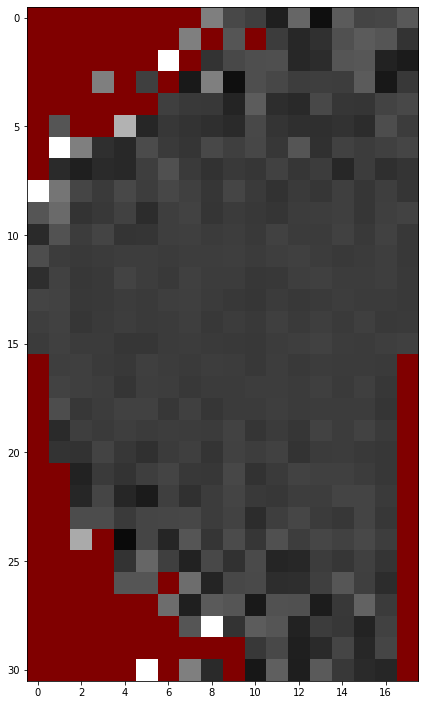

In [33]:
outsS = 0 #0-2 inclusive
basesS = 0 #0-7 inclusive

outsE = 0
basesE = 1
scoreMod = 0

matrixPixels = np.zeros((31,18,3), dtype=np.uint8)

start = gameState()
end = gameState()

for score in range(0,31):
    for inning in range(0,18):
        start.setFromData(inning, outsS, basesS, score - 15)
        end.setFromData(inning, outsE, basesE, score - 15 + scoreMod)
        
        val = stateTran[start.toNum()][end.toNum()]*255
        if(val == 0):
            matrixPixels[score, inning] = [128,0,0]
        else:
            matrixPixels[score, inning] = [val,val,val]

size = .4
fig, ax = plt.subplots(figsize=(18*size,31*size))
ax.imshow(matrixPixels)

In [109]:
def matrixMap1(y,x): #map the index to only the bases, all other info is irrelevent
    state = gameState()
    state.setFromNum(x)
    xNew = state.bases
    
    state.setFromNum(y)
    yNew = state.bases
    return xNew,yNew


baseDim = (8,8)
baseImage = Image.new('RGB', baseDim, "black")
basePixels = baseImage.load()

baseMatrix = np.zeros(baseDim)

stateConv = gameState() #used for the mapping
#map the large matrix to the base matrix
for y1 in range(matrixDim[0]):
    for x1 in range(matrixDim[1]):
        y2,x2 = matrixMap1(y1,x1)
        baseMatrix[y2][x2] += stateTran[y1][x1] #add the data to the proper spot in the new matrix
    if(y1 % 1000 == 0):
        print(100 * y1 / matrixDim[0], '%')
        
        
#change the matrix to a probability matrix, i.e. matrix[y][x] is probability from going to x, given that you are at
for row in range(baseDim[0]):
    rowSum = sum(baseMatrix[row])
    if(rowSum != 0):
        baseMatrix[row] = baseMatrix[row] / rowSum
        
for y in range(baseDim[0]): #fill image pixels
    for x in range(baseDim[1]):
        val = int(baseMatrix[y][x]*255)
        basePixels[x,y] = (val,val,val)
baseImage.show()

0.0 %
7.467144563918757 %
14.934289127837514 %
22.40143369175627 %
29.86857825567503 %
37.33572281959379 %
44.80286738351254 %
52.2700119474313 %
59.73715651135006 %
67.20430107526882 %
74.67144563918758 %
82.13859020310633 %
89.60573476702508 %
97.07287933094385 %


In [66]:
baseImage.show()
baseImage.save("base.png")

In [69]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
print(baseMatrix)

[[0.69  0.252 0.052 0.    0.007 0.    0.    0.   ]
 [0.327 0.293 0.112 0.192 0.008 0.035 0.033 0.   ]
 [0.244 0.071 0.331 0.113 0.166 0.072 0.002 0.   ]
 [0.289 0.006 0.023 0.282 0.043 0.102 0.104 0.151]
 [0.429 0.172 0.051 0.    0.23  0.118 0.    0.   ]
 [0.298 0.107 0.062 0.14  0.014 0.198 0.1   0.081]
 [0.248 0.065 0.119 0.008 0.112 0.08  0.225 0.142]
 [0.299 0.002 0.018 0.1   0.026 0.091 0.095 0.368]]


In [130]:
def matrixMap2(y,x): #mapping from matrix to inning position and score changes
    statePrev = gameState()
    stateNext = gameState()
    statePrev.setFromNum(y)
    stateNext.setFromNum(x)
   
    yNew = statePrev.outs*8 + statePrev.bases
    xNew = min(4,abs(stateNext.score - statePrev.score))*3*8 + stateNext.outs*8 + stateNext.bases #diff in score, bases, outs
    return yNew, xNew


baseDim = (8*3,8*3*5) #y axis is bases and outs, x is the next state which is next bases, outs, and change in score
baseImage = Image.new('RGB', (baseDim[1],baseDim[0]), "black")
basePixels = baseImage.load()

baseMatrix = np.zeros(baseDim)

stateConv = gameState() #used for the mapping
#map the large matrix to the base matrix
for y1 in range(matrixDim[0]):
    for x1 in range(matrixDim[1]):
        y2,x2 = matrixMap2(y1,x1)
        baseMatrix[y2][x2] += stateTran[y1][x1] #add the data to the proper spot in the new matrix
    if(y1 % 1000 == 0):
        print(100 * y1 / matrixDim[0], '%')
#change the matrix to a probability matrix, i.e. matrix[y][x] is probability from going to x, given that you are at
for row in range(baseDim[0]):
    rowSum = sum(baseMatrix[row])
    if(rowSum != 0):
        baseMatrix[row] = baseMatrix[row] / rowSum
        
for y in range(baseDim[0]):
    for x in range(baseDim[1]):
        val = int(baseMatrix[y][x]*255)
        basePixels[x,y] = (val,val,val)
baseImage.save("inningImage.png")

0.0 %
7.467144563918757 %
14.934289127837514 %
22.40143369175627 %
29.86857825567503 %
37.33572281959379 %
44.80286738351254 %
52.2700119474313 %
59.73715651135006 %
67.20430107526882 %
74.67144563918758 %
82.13859020310633 %
89.60573476702508 %
97.07287933094385 %


### Simulating the most likely game of baseball (with 2010-2019 data)

Simple task, just go from the starting state, and go to the next most probable state.

The results are unsurprising, except for the last inning.
Note: I have to verify that the 17th inning data is correct, and the last state is the draw flag.

In [14]:
#simulating the most average game
stateCurr = gameState()
statePrev = gameState()
stateCurr.setFromData(0,0,0,0)

totalChance = 1
prob = 1
iters = 0 #cut off after 50 states
while(prob != 0 and iters < 70): #while the game is still on
    totalChance = totalChance * prob
    #find the most likely next state
    nextStateNum = 0
    prob = 0 #probability
    for x in range(matrixDim[1]): 
        option = stateTran[stateCurr.toNum()][x]
        if(option > prob):
            prob = option #new probability
            nextStateNum = x
    statePrev.setFromNum(stateCurr.toNum())
    stateCurr.setFromNum(nextStateNum)
    iters = iters + 1
    
    print(statePrev)
    
print(totalChance, ", 1 in", 1/totalChance)

{'Inning': 0, 'Outs': 0, 'Bases': 000, 'Score': 0}
{'Inning': 0, 'Outs': 1, 'Bases': 000, 'Score': 0}
{'Inning': 0, 'Outs': 2, 'Bases': 000, 'Score': 0}
{'Inning': 1, 'Outs': 0, 'Bases': 000, 'Score': 0}
{'Inning': 1, 'Outs': 1, 'Bases': 000, 'Score': 0}
{'Inning': 1, 'Outs': 2, 'Bases': 000, 'Score': 0}
{'Inning': 2, 'Outs': 0, 'Bases': 000, 'Score': 0}
{'Inning': 2, 'Outs': 1, 'Bases': 000, 'Score': 0}
{'Inning': 2, 'Outs': 2, 'Bases': 000, 'Score': 0}
{'Inning': 3, 'Outs': 0, 'Bases': 000, 'Score': 0}
{'Inning': 3, 'Outs': 1, 'Bases': 000, 'Score': 0}
{'Inning': 3, 'Outs': 2, 'Bases': 000, 'Score': 0}
{'Inning': 4, 'Outs': 0, 'Bases': 000, 'Score': 0}
{'Inning': 4, 'Outs': 1, 'Bases': 000, 'Score': 0}
{'Inning': 4, 'Outs': 2, 'Bases': 000, 'Score': 0}
{'Inning': 5, 'Outs': 0, 'Bases': 000, 'Score': 0}
{'Inning': 5, 'Outs': 1, 'Bases': 000, 'Score': 0}
{'Inning': 5, 'Outs': 2, 'Bases': 000, 'Score': 0}
{'Inning': 6, 'Outs': 0, 'Bases': 000, 'Score': 0}
{'Inning': 6, 'Outs': 1, 'Bases

### Getting the win probability of the matrix

Here is an attempt at getting the probability of the home team winning using a recursive method. The issue is the branching factor is so large that the function takes far too long to run.

In [16]:
import time
#this method is far too slow
def winChance(transitionMatrix): #init of recursive function
    startState = gameState()
    startState.setFromData(0,0,0,0)
    return winChanceRecurs(transitionMatrix, startState.toNum())

def winChanceRecurs(data, y): #the probability of winning given the probability matrix
    #state = gameState() #debug
    #state.setFromNum(y) 
    #print(state)
    
    chance = 0
    dim = np.shape(data)
    isGameEnd = True
    for x in range(dim[1]):
        if(data[y][x] != 0):
            chance = chance + data[y][x]*winChanceRecurs(data, x)
            isGameEnd = False
    
    if(isGameEnd): #matrix had no prob values, must be the end of a game
        state = gameState()
        state.setFromNum(y) #set state, must be end state flag
        return int(state.getEndResult() == 1) #prob of 1 if the end state was a home win
            
    return chance

startTime = time.time()
#winRate = winChance(stateTran)
#print(winRate)
print("Time elapsed: ", time.time() - startTime)

Time elapsed:  0.0


In [35]:
startTime = time.time()

startState = gameState()
endState = gameState()
startState.setFromData(0,0,0,0)

winMatrix = np.linalg.matrix_power(stateTran, 512) #almost any game should be over by 512 states or "plays"

y = startState.toNum()

for x in range(matrixDim[1]):
    if(winMatrix[y][x] > .000001):
        endState.setFromNum(x)
        print(endState, ", chance: ", winMatrix[y][x])
print("Time elapsed: ", time.time() - startTime)

{'Inning': 0, 'Outs': 0, 'Bases': 000, 'Score': 1} , chance:  0.48198233298358917
{'Inning': 0, 'Outs': 0, 'Bases': 000, 'Score': 2} , chance:  0.5180176670164035
Time elapsed:  1716.050999879837
